In [417]:
#Project #2: Titanic - Who will survive?
#By: George Cheng & Dylan Lai
#Contribution Information: First Line of the Cell
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import sklearn.neighbors as skln
import sklearn.metrics as sklm
import sklearn.cluster as sklc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
import random

titanic = pd.read_csv('train.csv')
test = pd.read_csv('test.csv') #This was later found out to contain no "Survived" column, so couldn't be used for 
#testing the training set. Instead, the training data was split into training and testing set.

#Dropped Columns: Ticket, Cabin, Name
#The ticket number of the passenger are all unique and don't have a concrete format. 
#Therefore, no analysis could be done on the ticket number and thus is dropped.
#The cabin number has lots of missing data and they can't be easily imputed (no average cabin number). 
#Thus, we drop the column 'cabin'.
#The names of the passengers don't really determine much and most are unique. 
#Thus, no analysis can be done on their name and thus is dropped.
titanic = titanic.drop('Ticket', axis=1)
titanic = titanic.drop('Cabin', axis=1)
titanic = titanic.drop('Name', axis=1)
titanic

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [418]:
#Dylan Lai
#In our look at the data, we have found many empty age features, so we decided to impute them.
#We find the mean for age, rounded it for simplicity, then imputed any missing values in Age with mean imputation. 
titanic_meanAge = round(titanic['Age'].mean(), 1)
titanic['Age'].fillna(titanic_meanAge, inplace = True)
titanic
#It didn't seem important in our cleaning to think about outliers in the age as none of the entries had ages that
# seemed unreasonable.

#We also found one unfilled embarked feature, but we deemed the imputation of the missing embarked location to not
# affect our overall analysis, so it is imputed randomly.
randInt = int(round(2*random.random()))
if randInt == 0:
    print('Q')
    titanic['Embarked'].fillna('Q',inplace=True)
if randInt == 1:
    print('S')
    titanic['Embarked'].fillna('S',inplace=True)
if randInt == 2:
    print('C')
    titanic['Embarked'].fillna('C',inplace=True)
print(titanic['Embarked'][60:65])

S
60    C
61    S
62    S
63    S
64    C
Name: Embarked, dtype: object


In [419]:
#Dylan Lai
# In the fares column, we have the feature has many outliers and some fares that were put as 0.
titanic_dropFares = pd.DataFrame(titanic)
#This loop removes all entries that have a fare of 0 or less for calculating the mean, since 
#those entries are presumed to be missing values due to their unreasonable value of 0. 
#The calculated mean will be used to impute those entries.
for x in titanic_dropFares.index:
  if titanic_dropFares.loc[x, "Fare"] <= 0:
    titanic_dropFares.drop(x, inplace = True)

#We seperated the entries into pclass and then averaged the fares of those with the same pclass, since 
titanic_averageFare = titanic_dropFares.groupby(by = 'Pclass').mean()
print(titanic_averageFare)

#Seperate dataframe into 3, spliting them across each ticket class x (['Pclass'] == x) because the ticket price is
#correlated to the ticket class the passenger purchased.
df1 = titanic[titanic['Pclass'] == 1]
df2 = titanic[titanic['Pclass'] == 2]
df3 = titanic[titanic['Pclass'] == 3]

#For each of the split dataframes, we found the 25th and 75th percentile of the variable Fare and then 
#found the difference to find the interquartile range.
#We calculate the Outliers with the formula:  Q3 + 1.5IQR AND Q1 - 1.5 IQR
q75, q25 = np.percentile (df1['Fare'], [75, 25])
iqr1 = q75 - q25
outlier_max1 = 1.5*iqr1 + q75
outlier_min1 = q25 - 1.5*iqr1
print('outlier max class 1: '+ str(outlier_max1))
print('outlier min class 1: '+ str(outlier_min1))

q75, q25 = np.percentile (df2['Fare'], [75, 25])
iqr2 = q75 - q25
outlier_max2 = 1.5*iqr2 + q75
outlier_min2 = q25 - 1.5*iqr2
print('outlier max class 2: '+ str(outlier_max2))
print('outlier min class 2: '+ str(outlier_min2))

q75, q25 = np.percentile (df3['Fare'], [75, 25])
iqr3 = q75 - q25
outlier_max3 = 1.5*iqr3 + q75
outlier_min3 = q25 - 1.5*iqr3
print('outlier max class 3: '+ str(outlier_max3))
print('outlier min class 3: '+ str(outlier_min3))

#All Fare = 0 entries are imputed with the mean of their respective ticket class
for x in df1.index:
    if df1.loc[x, "Fare"] == 0:
        titanic.loc[x,"Fare"]=titanic_averageFare['Fare'][1]
for x in df2.index:
    if df2.loc[x, "Fare"] == 0:
        titanic.loc[x,"Fare"]=titanic_averageFare['Fare'][2]
for x in df3.index:
    if df3.loc[x, "Fare"] == 0:
        titanic.loc[x,"Fare"]=titanic_averageFare['Fare'][3]
        

        PassengerId  Survived        Age     SibSp     Parch       Fare
Pclass                                                                 
1        456.687204  0.644550  37.090142  0.426540  0.364929  86.148874
2        443.859551  0.488764  29.872640  0.415730  0.393258  21.358661
3        439.983573  0.242300  26.355483  0.620123  0.396304  13.787875
outlier max class 1: 187.364075
outlier min class 1: -62.940125
outlier max class 2: 45.5
outlier min class 2: -6.5
outlier max class 3: 27.125
outlier min class 3: -3.875


In [420]:
#George Cheng
#Count the entries by Pclass
titanic_count = titanic.groupby(by = 'Pclass').count()
print(titanic_count)
#We decided to replace all outliers with their pclass's average fare. Originally, we did decide to drop them, but 
# we saw the number of removed entries for each pclass (shown below) and felt that the 7.83% of the data was too much
# data dropped for the analysis. 
for x in df1.index:
    if df1.loc[x, "Fare"] >= outlier_max1:
        titanic["Fare"] = titanic["Fare"].replace([df1.loc[x, "Fare"]],titanic_averageFare['Fare'][1])
    if df1.loc[x, "Fare"] <= outlier_min1:
        titanic["Fare"] = titanic["Fare"].replace([df1.loc[x, "Fare"]],titanic_averageFare['Fare'][1])

#Changed instead of removed
#Removed 20 entries (There are 216 entries, so removing 20/216 = 9.259% of the 1st ticket class population)

for x in df2.index:
    if df2.loc[x, "Fare"] >= outlier_max2:
        titanic["Fare"] = titanic["Fare"].replace([df2.loc[x, "Fare"]],titanic_averageFare['Fare'][2])
    if df2.loc[x, "Fare"] <= outlier_min2:
        titanic["Fare"] = titanic["Fare"].replace([df2.loc[x, "Fare"]],titanic_averageFare['Fare'][2])

#Changed instead of removed
#Removed 7 entries (There are 184 entries, so removing 7/184 = 3.8% of the 2nd ticket class population)

for x in df3.index:
    if df3.loc[x, "Fare"] >= outlier_max3:
        titanic["Fare"] = titanic["Fare"].replace([df3.loc[x, "Fare"]],titanic_averageFare['Fare'][3])
    if df3.loc[x, "Fare"] <= outlier_min3:
        titanic["Fare"] = titanic["Fare"].replace([df3.loc[x, "Fare"]],titanic_averageFare['Fare'][3])
print(titanic)

#Changed instead of removed
#Removed 52 entries (There are 491 entries, so removing 52/491 = 10.59% of the 3rd ticket class population)

#WITH THIS, THE DATA IS DEEMED TO BE CLEANED!

        PassengerId  Survived  Sex  Age  SibSp  Parch  Fare  Embarked
Pclass                                                               
1               216       216  216  216    216    216   216       216
2               184       184  184  184    184    184   184       184
3               491       491  491  491    491    491   491       491
     PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare  \
0              1         0       3    male  22.0      1      0   7.2500   
1              2         1       1  female  38.0      1      0  71.2833   
2              3         1       3  female  26.0      0      0   7.9250   
3              4         1       1  female  35.0      1      0  53.1000   
4              5         0       3    male  35.0      0      0   8.0500   
..           ...       ...     ...     ...   ...    ...    ...      ...   
886          887         0       2    male  27.0      0      0  13.0000   
887          888         1       1  female  19.0  

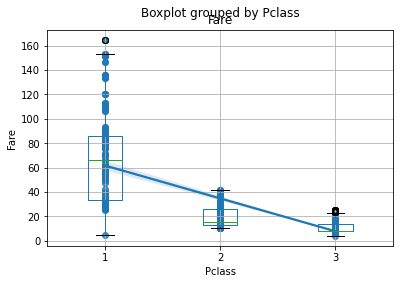

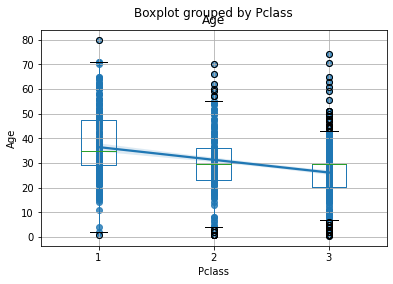

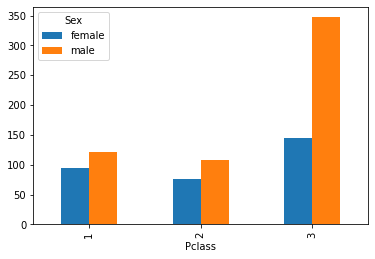

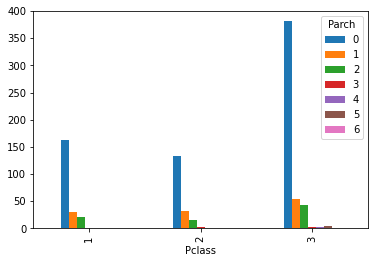

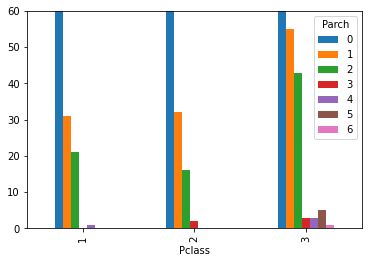

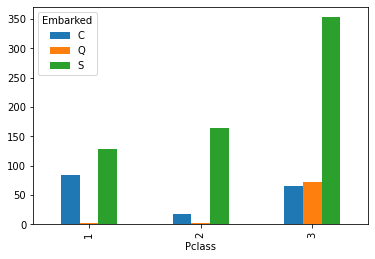

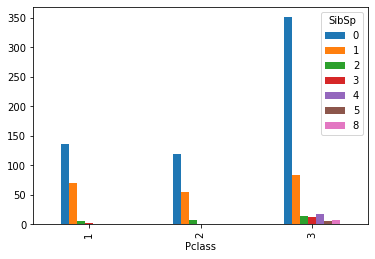

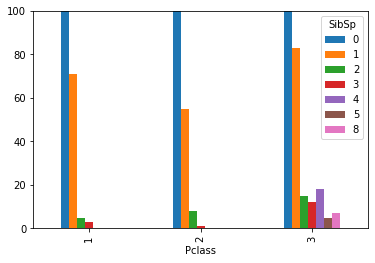

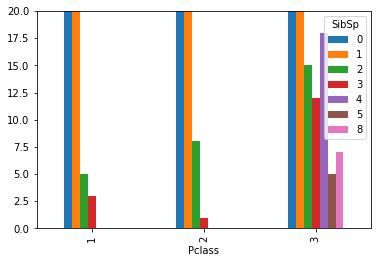

In [421]:
#George Cheng
#The ticket class of a passenger seemed to be a good indicator of their socio-economic status as fare was
# correlated with their ticket class. The ticket class 1 was the most expensive and the ticket class 3
# 3 was the least expensive.
titanic.boxplot(column = 'Fare', by = 'Pclass')
sea.regplot(x = titanic['Pclass'], y = titanic['Fare'])


#To see how age is affected by Pclass, a box and whisker plot and a regression line from a scatter plot
# with the same attributes (Pclass vs. Age) is drawn. They both show a decrease in the age the lesser 
# socio-economic status. This could be a result of younger people having spent less time working and thus poorer.
titanic.boxplot(column = 'Age', by = 'Pclass')
sea.regplot(x = titanic['Pclass'], y = titanic['Age'])

#To see how gender is affected by Pclass, they were grouped together by Pclass and Sex and then plotted by count 
# as a bar graph. In the bar graph, the females were always less than the males, regardless of the Pclass. However,
# it seems like there is a significant number of males compared to females in the 3rd Pclass, almost twice the number
# of males compared to number females.

titanic_gender=titanic.groupby(['Pclass','Sex']).size()
titanic_gender=titanic_gender.unstack()
titanic_gender.plot(kind='bar')

#To see how the number of parents and children are affected by Pclass, a bar graph similar in implementation to 
# the Sex vs Pclass is done.
titanic_parch=titanic.groupby(['Pclass', 'Parch']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#The number of Parch being 0 is very prominent compared to every other number for the attribute Parch. The number 
# of Parch that were greater than 0 was so small compared that the same graph was made, but the y limit was set to 60
# ,so the other Parch attribute counts could be looked at. Overall, it seemed like a Power Law Distribution.
# Regardless of Pclass, most have Parch = 0, 1, or 2. Then, there are the very few that have Parch > 2
titanic_parch=titanic.groupby(['Pclass', 'Parch']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,60)

#Where the passenger embarked vs. their Pclass was also compared via bar graph. It seems to indicate that these places
# have different socioeconomic statuses. Queenstown seem to be the most prominent as barely any Pclass 1 or Pclass 2 
# was purchased in that port, almost all tickets were class 3, which makes Queenstown seem very poor. Cherbourg has 
# less people buying the class 3 ticket than class 1 tickets, showing that the population of Cherbourg seems to be 
# very wealthy. Southampton seems to have a Power Law Distribution, most people bought the cheapest ticket (Pclass 
# = 3)and the least people buying the most expensive ticket (Pclass = 1). This seems to indicate that Southampton 
# residents are average in wealth.
titanic_parch=titanic.groupby(['Pclass', 'Embarked']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#Finally, the class of the ticket is compared to the Sibsp of the passenger via another bar graph. 
# Like the Parent/Child graph, 0 siblings/Spouses is far greater than all the others
titanic_parch=titanic.groupby(['Pclass', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#In order to show the other groups more effectively, we set the limit of the graph to 100
# 1 siblings/Spouses is still far greater than the rest
titanic_parch=titanic.groupby(['Pclass', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,100)

#To show the other number of siblings and spouses effectively, we now set the limit to 20 
# A power law distribution would be most effective in representing this data
# While 0 siblings/Spouses is most common in all 3 classes, in 3rd class the number is far greater than in the other classes
# This suggests that a larger portion of those in 3rd class are single and have no siblings
titanic_parch=titanic.groupby(['Pclass', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,20)

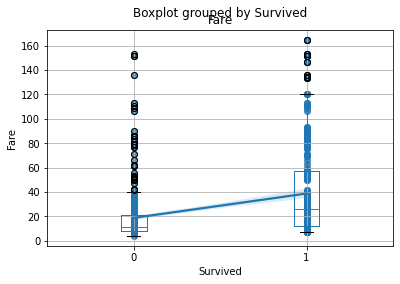

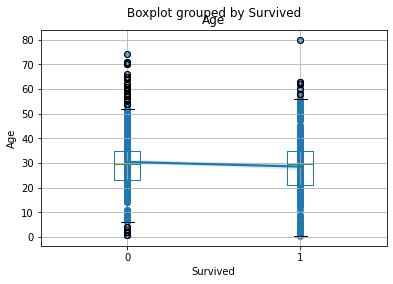

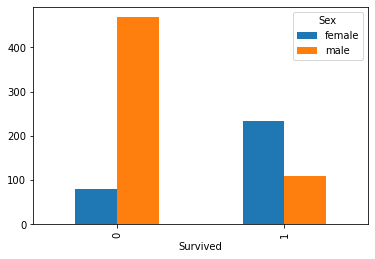

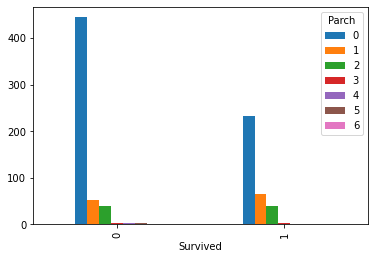

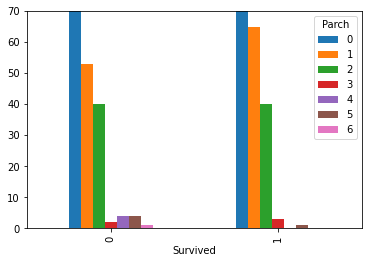

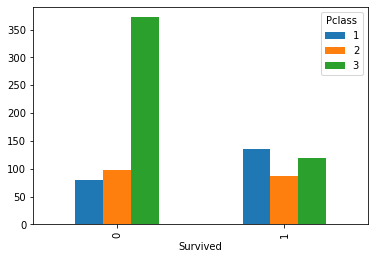

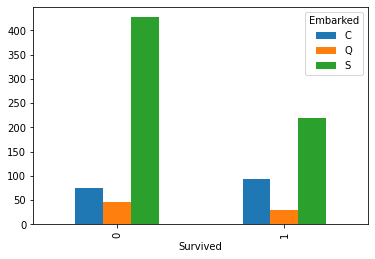

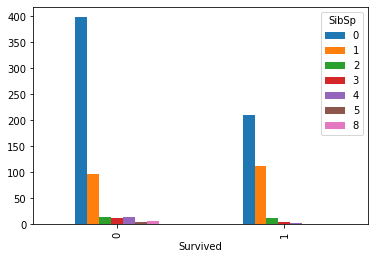

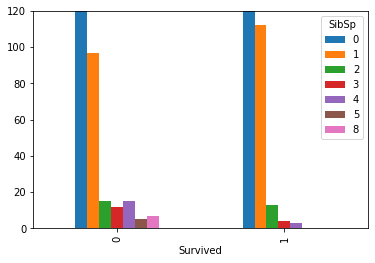

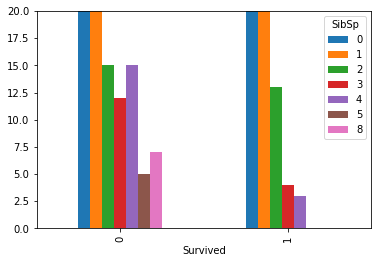

In [422]:
#George Cheng & Dylan Lai
#The fare of a passenger seemed to be a good indicator of their survial, but that may be because fare was
# correlated with their ticket class and number of Parent/Childs.
titanic.boxplot(column = 'Fare', by = 'Survived')
sea.regplot(x = titanic['Survived']+1, y = titanic['Fare'])

#To see how age affected surival, a box and whisker plot from a scatter plot with the same attributes (Survived vs.
# Age) is drawn. They both show an average age of 30 for survived and not suvived.
# This suggests that the average age on the ship was 30 and the survival was distributed approximately normally. 
# However, there were less outliers for the box and whisker plot that survived
# This suggests that thre was a higher variance in the ages of those that survived
titanic.boxplot(column = 'Age', by = 'Survived')
sea.regplot(x = titanic['Survived']+1, y = titanic['Age'])

#To see how gender affected survival, they were grouped together by Survived and Sex and then plotted by count as a 
# bar graph. In the bar graph, the females were less than the males for not survived, but greater than males for 
# survived. This suggests that females had a greater survival rate.
titanic_gender=titanic.groupby(['Survived','Sex']).size()
titanic_gender=titanic_gender.unstack()
titanic_gender.plot(kind='bar')

#To see how the number of parents and children affected suvival, a bar graph similar in implementation to 
# the Sex vs Survived is done.
titanic_parch=titanic.groupby(['Survived', 'Parch']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#The number of Parch being 0 is very prominent compared to every other number for the attribute Parch. 
# The number of Parch that were greater than 0 was so small compared that the same graph was made,
# but the y limit was set to 70 so the other Parch attribute counts could be looked at. 
# Overall, it seemes like a Power Law Distribution.
# Regardless of Survival, most have Parch = 0, 1, or 2. Then, there are the very few that have Parch > 2
# Those that did not have a child had a much greater chance of not surviving.
# Those that only had one child had a slightly lower chance of surviving.
# Those with 2 children had approximately equal chance of surviving or not surviving
titanic_parch=titanic.groupby(['Survived', 'Parch']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,70)

#The socioeconomic class represented via ticket clas vs survival is compared using a bar graph
# For 3rd class tickets, the number that did not survive was much greater than those that did survive
# This suggests that being 3rd class means you are less likely to survive
titanic_pclass=titanic.groupby(['Survived', 'Pclass']).size()
titanic_pclass=titanic_pclass.unstack()
ax = titanic_pclass.plot(kind='bar')

#Where the passenger embarked vs. their survival was also compared via bar graph. 
# For both Southhampton and Queenstown, the portion that survived was less than those that did not survive
# However, for Cherbourg, the portion that survived was slightly greater than those that did not survive
# This suggests that embarking from Cherbourg indicated a greater chance for survival,
# but from our previous analysis of the socioeconomic status of Cherbourg, Cherbourg is likely also a wealthy location.
# Thus the reason that embarking from Cherbourg indicated a greater chance for survival is due to socioeconomic status.
titanic_parch=titanic.groupby(['Survived', 'Embarked']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#Finally, survival is compared to the Sibsp of the passenger via another bar graph.
# Like the Parent/Child graph, 0 siblings/Spouses is far greater than all the others
titanic_parch=titanic.groupby(['Survived', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#In order to show the other groups more effectively, we set the limit of the graph to 120
# 1 siblings/Spouses is still far greater than the rest
titanic_parch=titanic.groupby(['Survived', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,120)

#In order to show the other groups more effectively, we set the limit of the graph to 20
# 1 siblings/Spouses is still far greater than the rest
# A power law distribution would be best to represent this data
# While 0 siblings/Spouses is much larger in both survived and not survived, 
# there are much more with 0 siblings/Spouses that did not survive.
# This suggests that those with no family had a lower chance of survivng
titanic_parch=titanic.groupby(['Survived', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,20)

In [423]:
#Dylan Lai
#For non-numerical features, we assign a number to each category (example: male = 0, female = 0) before comparing them
print('Correlation between Fare and Survived: '+str(titanic["Survived"].corr(titanic["Fare"])))
print('Correlation between Age and Survived: '+str(titanic["Survived"].corr(titanic["Age"])))
titanic_Sex = titanic['Sex'].map({'male':0,'female':1})
print('Correlation between Sex and Survived: '+str(titanic["Survived"].corr(titanic_Sex)))
print('Correlation between Parents/Children and Survived: '+str(titanic["Survived"].corr(titanic["Parch"])))
print('Correlation between Ticket class and Survived: '+str(titanic["Survived"].corr(titanic["Pclass"])))
titanic_Embark = titanic['Embarked'].map({'C':0,'Q':1,'S':2})
print('Correlation between Embarked location and Survived: '+str(titanic["Survived"].corr(titanic_Embark)))
print('Correlation between Siblings/Spouses and Survived: '+str(titanic["Survived"].corr(titanic["SibSp"])))
#The correlations with the largest absolute value has are the most correlated. With this in mind, Sex, Ticket class, 
# and Fare seem to be the most important based on their correlation with Survived, and are the features we will use
# for our analysis. 

Correlation between Fare and Survived: 0.3235322233818887
Correlation between Age and Survived: -0.06981101300650602
Correlation between Sex and Survived: 0.543351380657755
Correlation between Parents/Children and Survived: 0.08162940708348365
Correlation between Ticket class and Survived: -0.33848103596101475
Correlation between Embarked location and Survived: -0.16767531386772117
Correlation between Siblings/Spouses and Survived: -0.03532249888573559


In [424]:
#George Cheng & Dylan Lai
#We dropped all of the non important columns from the dataset, but also, dropped Sex as it is non numerical. We then
# inserted the Sex column that was transformed to be numerical (male = 0, female = 1).
#Then, since the original testing data had no survived column, we had to improvise with splitting the training data 
# into 75% training set and 25% testing set.
titanic_data=titanic.drop(columns = ['Sex', 'Embarked','Age','Parch','SibSp','PassengerId'], axis=1)
titanic_data.insert(3,'Sex',titanic_Sex)
titanic_training = titanic_data[0:int(round(titanic['Sex'].size*.75,0))]
titanic_testing = titanic_data[int((round(titanic['Sex'].size*.75,0))+1):]
titanic_data = titanic_data.reset_index(drop=True)
print(titanic_data)

#Here, we made Survived our class by dropping them from the features (x, independent variable) and then adding them 
# to our target class (y, dependent variable). 
train_x = titanic_training.drop(columns=['Survived'],axis=1)
train_y = titanic_training['Survived']
test_x = titanic_testing.drop(columns=['Survived'],axis=1)
test_y = titanic_testing['Survived']

     Survived  Pclass     Fare  Sex
0           0       3   7.2500    0
1           1       1  71.2833    1
2           1       3   7.9250    1
3           1       1  53.1000    1
4           0       3   8.0500    0
..        ...     ...      ...  ...
886         0       2  13.0000    0
887         1       1  30.0000    1
888         0       3  23.4500    1
889         1       1  30.0000    0
890         0       3   7.7500    0

[891 rows x 4 columns]


In [425]:
#Dylan Lai
#KNearestNeighbor Classifier
#K-Nearest Neighbor Classifer groups sets of K elements together that have been labeled. 
#The label that appears in the grouping the most decides the classification that the entire group is labeled in each
# group. 
#Using these labels, we can split the data by how it was classified in each grouping.
Kmodel = skln.KNeighborsClassifier()
Kmodel.fit(train_x,train_y)
#We tested with a few different k neighbor values, and we settled on 17 as it seemed to be the best
Kmodel.n_neighbors = 17
predict_train = Kmodel.predict(train_x)
predict_test = Kmodel.predict(test_x)
accuracy_test = sklm.accuracy_score(test_y,predict_test)
print('Accuracy on test dataset',accuracy_test)
#The accuracy for the K Nearest Neighbors Model is pretty good as 78.38% is close to 80%, an accuracy precentage that
# was decided to be a standard for our models.
precision_test = sklm.precision_recall_fscore_support(test_y, predict_test, average = 'binary')
print ('Precision_test : ', precision_test)
#The precision_recall_fscore_support method allows to show the precision, recall, f score, and number of 
# instances of each class predicted. In our case, we decide to average out these scores and the result are:
#Precision = 0.71795
#Recall = 0.68293
#Fscore = 0.7
#The precision of the K-Nearest Neighbors is 71.795%. If (precision)^(-1), we will find out the precentage of 
# false positives compared to true positives. In this case, (.71795)^-1 = 1.3928 = (true positive/true positive = 1) + 
# (false positive/true positive), which shows the ratio of false to true positive as .3928 : 1 or 1: 2.5455, which 
# shows that the precision score is ok as it means there are 2 false positives for every 5 true positives, a fair 
# ratio. 
# The recall of the K-Nearest Neighbors is 68.293%. If we invert the formula like for precision, we find out that 
# (true positive + false negatives / true positive) = 1.464. The ratio comes out to be 1: 2.154 for false negatives to
# true positives, a fair recall score as less than 1/3 of all the predicted positives are wrong. 
# The F score is similar to the accuracy test, but it considered even better as it takes into account both recall and 
# precision. The F score for this algorithm is 70% This means that the algorithm is pretty good as it is better than 
# a 50% fair coin flip, but not very good as it is much less than 80% accurate.

Accuracy on test dataset 0.7837837837837838
Precision_test :  (0.717948717948718, 0.6829268292682927, 0.7000000000000001, None)


In [426]:
#Dylan Lai
#Logistic Regression
#Logistic Regression uses a logistic function to convert variables into probabilites
#h(x,w) = w_0 + sum(from i=1 to m-1, w_i*x_i)
#f(x) = 1/(1+e^-h(x,w))
#This ensures that the values will be between 0 and 1
#The regression is assuming the data it is classifying has a binary classification(Either 1 or 0)
#Coefficient w for the regression is made so that high 'probabilites' correspond to a 1 classification
#and low 'proabilities' correspond to a 0 classification
#A cost function is also used to value each probability,
#a higher cost/loss function value means the prediction would be more wrong
LogisticModel = LogisticRegression()
LogisticModel.fit(train_x,train_y)

#We have the logstic model fit itself with the traing data and then have it print its coefficient and intercept, to
# show the weight it puts behind each feature, when predicting the class.
print('Coefficient of model :', LogisticModel.coef_)
print('Intercept of model', LogisticModel.intercept_)
predict_test = LogisticModel.predict(test_x)

accuracy_test = sklm.accuracy_score(test_y,predict_test)
#The accuracy for the Logistic Regression is pretty good as 78.83% is close to 80%, an accuracy precentage that
# was decided to be a standard for our models.
print('accuracy_score on test dataset : ', accuracy_test)
precision_test = sklm.precision_recall_fscore_support(test_y, predict_test, average = 'binary')
print ('Precision_test : ', precision_test)
#The precision_recall_fscore_support method allows to show the precision, recall, f score, and number of 
# instances of each class predicted. In our case, we decide to average out these scores and the result are:
#Precision = 0.74648
#Recall = 0.64634
#Fscore = 0.69281
#The precision of the Logistic Regression is 74.648%. If precision is inverted, we will find out the precentage of 
#false positives compared to true positives. In this case, (.74648)^-1 = 1.3396 = (true positive/true positive = 1) + 
# (false positive/true positive), which shows the ratio of false to true positive as .3396 : 1 or 1: 2.9, which shows 
# that the precision score is fair as it means there is a false positive for every 2.9 true positives, a fair
# ratio. 
# The recall of the Logistic Regression is 64.634%. If we invert the formula like for precision, we find out that 
# (true positive + false negatives / true positive) = 1.547. The ratio (which is the same process as
# precision) seems to be 1: 1.547 for false negatives to true positives, which means that 1/3 of all the positives
# were not true.
# The F score is similar to the accuracy test, but it considered even better. The F score for this algorithm is 
# 69.281%. This means that the algorithm is good as it is better than a 50% coin flip, but not very good as it is
# much less than 80% accurate.

Coefficient of model : [[-8.44479082e-01  1.03108276e-03  2.53102928e+00]]
Intercept of model [0.41083833]
accuracy_score on test dataset :  0.7882882882882883
Precision_test :  (0.7464788732394366, 0.6463414634146342, 0.69281045751634, None)


In [427]:
#George Cheng
#The Machine Learning Algorithm used here is the Decision Tree Classifier Algorithm.
#For this algorithm, a feature is selected to be the root and then the branches, which represents a value or range 
# of values of that root feature, are formed from the root, seperating the data into each branch, where the data is
# has that root feature be that value or range of values. 
#Then, nodes are formed from the split data and for each node, the process is done again and again with another 
# feature not selected yet from the branch until all of the split data in a particular node has all the same class or
# no more attributes can be selected from a particular node.
#If the split has all the same process, the process is terminated for that node and it becomes a leaf with its class 
# being the class that the data has.
#If there are no more attributes to select from, all that split data will be used to see what class appears more 
# often. The node is terminated and becomes a leaf with the class that appears more often in the data. 
#Each record in the testing set will be checked against the tree with the record starting from the root of the tree
# and going to branches that fit the attribute it has and does this until it reaches a leaf with a class, that will
# be the class the decision tree classifier predicts it has. 

DecisionModel = DecisionTreeClassifier()

DecisionModel.fit(train_x,train_y)
predict_test = DecisionModel.predict(test_x)

accuracy_test = sklm.accuracy_score(test_y,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)
#The accuracy of the Decision Tree Classifier seems to be quite high, as it is above the 80% threshold we imposed.
precision_test = sklm.precision_recall_fscore_support(test_y, predict_test, average = 'binary')
print ('Precision_test : ', precision_test)
#The precision_recall_fscore_support method allows to show the precision, recall, f score, and number of 
# instances of each class predicted. In our case, we decide to average out these scores and the result are:
#Precision = 0.80282
#Recall = 0.69512
#Fscore = 0.74510
#The precision of the Decision Tree Classifier is 80.282%. If (precision)^(-1), we will find out the precentage of 
#false positives compared to true positives. In this case, (.80282)^-1 = 1.2456 = (true positive/true positive = 1) + 
# (false positive/true positive), which shows the ratio of false to true positive as .2456 : 1 or 1: 4.1, which shows 
# that the precision score is good as it means there is a false positive for every 4.1 true positives, a low
# ratio. 
# The recall of the Decision Tree Classifier is 69.512%. If we invert the formula like for precision, we find out that 
# (true positive + false negatives / true positive) = 1.4386. This shows that for there is almost 1 false negative for 
# every 2.2799 true positives, meaning about 30% of all positive predictions were wrong. This seems quite high thus, 
# is a very poor recall score. 
# F score is considered a better test of accuracy and overall, the F score is 74.510%, a good score that is better 
# than 50% coin flip, but also, not ver]]]]]]]y good as it is lower than 80%.

accuracy_score on test dataset :  0.8243243243243243
Precision_test :  (0.8028169014084507, 0.6951219512195121, 0.7450980392156863, None)


In [428]:
#George Cheng & Dylan Lai
#We seperate our data into the Survived columns and every other column
X = titanic_data.iloc[:,1:]
y = titanic_data.iloc[:,0]
#For Cross Validation, we use "Leave-One-Out" Cross Validation, meaning that the entire dataset is all going to become 
# training data, except for one entry that is testing data. This will be repeated the number of entries times and 
# the average accuracy, precision, recall, and F-score will be calculated afterwards.
#We will have a similar code for each, but it uses the 3 different machine learning algorithm (same order as earlier).
# CROSS VALIDATION: k-Nearest Neighbors
k = 891 # n = 891
kf = KFold(n_splits=k, random_state=None)
#Arrays for our accuracy, precision, recall, and F-score to go into.
acc_score = []
precision_score = []
recall_score = []
F_score = []
counter = 0


for train_index , test_index in kf.split(X):
    counter=counter+1
    #Seperates the data into testing and training sets by the k folds given
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    #Used the same k_neighbor value as before
    Kmodel.fit(X_train,y_train)
    pred_values = Kmodel.predict(X_test)
    
    #The accuracy, precision, recall, and F-score are put into the arrays for later averaging.
    acc = sklm.accuracy_score(pred_values , y_test)
    acc_score.append(acc)
    precision_test = sklm.precision_recall_fscore_support(y_test, pred_values, average = 'binary', zero_division= 1)
    precision_score.append(precision_test[0])
    recall_score.append(precision_test[1])
    F_score.append(precision_test[2])
    #The precision_recall_fscore_support method allows to show the precision, recall, f score, and number of 
    # instances of each class predicted. 
    #If precision is inverted, we will find out the precentage of false positives compared to true positives. 
    # precision^(-1)=1+TP/FP
    # The recall is (true positive + false negatives / true positive). 
    # F score is considered a better test of accuracy, the F score is 2*(precision*recall)/(precision+recall)
avg_acc_score = sum(acc_score)/k
#here we averaged the precision, recall, and F-scores
avg_precison_score = sum(precision_score)/k
avg_recall_score = sum(recall_score)/k
avg_F_score = sum(F_score)/k
print('Average Precision Test(precision, recall, F-score) :', '('+str(avg_precison_score)+', '+str(avg_recall_score)+', '+str(avg_F_score)+')')
#The average precision of this Cross Validation is 88.215%. 
#(.88215)^-1 = 1.13 = 1 + (false positive/true positive), 
#which shows the ratio of false to true positive as .13359 : 1 or 1: 7.485, 
#which shows that the precision score is very good as it means there is around 2 false positives for every 15 true 
# positives, a very good ratio.
# The average recall of this Cross Validation is 88.55%. The inversion is 
# (true positive + false negatives / true positive) = 1.129. 
# the ratio of false negatives to true positives as .129 : 1 or 1: 7.734
# This shows that for there is around 4 false negatives for every 31 true positives, an amazing ratio.
# The average F-score of this Cross Validation is 76.768%, a pretty good score as it is much better than a 50% fair
# coin flip, but not the standard of 80% accuracy that we imposed.
print('Avg accuracy : {}'.format(avg_acc_score))
#Here, we noticed that out average accuracy was the same as our average F-score, we weren't able to figure this out
# yet. 


Average Precision Test(precision, recall, F-score) : (0.8821548821548821, 0.8855218855218855, 0.7676767676767676)
Avg accuracy : 0.7676767676767676


In [429]:
#George Cheng & Dylan Lai
# CROSS VALIDATION: Logistic Regression
k = 891
kf = KFold(n_splits=k, random_state=None)

acc_score = []
precision_score = []
recall_score = []
F_score = []
counter = 0

for train_index , test_index in kf.split(X):
    counter=counter+1
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    LogisticModel.fit(X_train,y_train)
    pred_values = LogisticModel.predict(X_test)
     
    acc = sklm.accuracy_score(pred_values , y_test)
    acc_score.append(acc)
    precision_test = sklm.precision_recall_fscore_support(y_test, pred_values, average = 'binary', zero_division = 1)
    precision_score.append(precision_test[0])
    recall_score.append(precision_test[1])
    F_score.append(precision_test[2])
    #The precision_recall_fscore_support method allows to show the precision, recall, f score, and number of 
    # instances of each class predicted. 
    #If precision is inverted, we will find out the precentage of false positives compared to true positives. 
    # precision^(-1)=1+TP/FP
    # The recall is (true positive + false negatives / true positive). 
    # If we invert the formula like for precision, we find 
    # (true positive + false negatives / true positives) = 1 + falseNegatives/truePostives
    # F score is considered a better test of accuracy, the F score is 2*(precision*recall)/(precision+recall)
avg_acc_score = sum(acc_score)/k
#here we averaged the precision, recall, and F-scores
avg_precison_score = sum(precision_score)/k
avg_recall_score = sum(recall_score)/k
avg_F_score = sum(F_score)/k
print('Average Precision Test(precision, recall, F-score) :', '('+str(avg_precison_score)+', '+str(avg_recall_score)+', '+str(avg_F_score)+')')
#The average precision of the Cross Validation is 90.909%. 
#(.90909)^-1 = 1.100 = 1 + (false positive/true positive), 
# which shows the ratio of false to true positive as .100 : 1 or 1: 10, 
#which shows that the precision score is very good as it means there are around a false positive for every 10 true 
# positives, a very good ratio.
# The average recall of the Cross Validation is 87.767%. The inversion is 
# (true positive + false negatives / true positive) = 1.139. 
# the ratio of false negatives to true positives as .139 : 1 or 1: 7.175
# This shows that for there is around 6 false negative for every 43 true positives, a very great ratio.
# The average F-score of the Cross Validation is 78.676%, a good score that is better 
# than 50% coin flip, but also, not very good as it is lower than 80%.
print('Avg accuracy : {}'.format(avg_acc_score))

Average Precision Test(precision, recall, F-score) : (0.9090909090909091, 0.877665544332211, 0.7867564534231201)
Avg accuracy : 0.7867564534231201


In [430]:
#George Cheng & Dylan Lai
# CROSS VALIDATION: Decision Tree Algorithm
k = 891
kf = KFold(n_splits=k, random_state=None)
acc_score = []
precision_score = []
recall_score = []
F_score = []
counter = 0
for train_index , test_index in kf.split(X):
    counter=counter+1
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    modeld.fit(X_train,y_train)
    pred_values = modeld.predict(X_test)
     
    acc = sklm.accuracy_score(pred_values , y_test)
    acc_score.append(acc)
    precision_test = sklm.precision_recall_fscore_support(y_test, pred_values, average = 'binary', zero_division = 1)
    precision_score.append(precision_test[0])
    recall_score.append(precision_test[1])
    F_score.append(precision_test[2])
    #The precision_recall_fscore_support method allows to show the precision, recall, f score, and number of 
    # instances of each class predicted. 
    # If precision is inverted, we will find out the precentage of false positives compared to true positives. 
    # precision^(-1)=1+TP/FP
    # The recall is (true positive + false negatives / true positive). 
    # F score is considered a better test of accuracy, the F score is 2*(precision*recall)/(precision+recall)
avg_acc_score = sum(acc_score)/k
#here we averaged the precision, recall, and F-scores
avg_precison_score = sum(precision_score)/k
avg_recall_score = sum(recall_score)/k
avg_F_score = sum(F_score)/k
print('Average Precision Test(precision, recall, F-score) :', '('+str(avg_precison_score)+', '+str(avg_recall_score)+', '+str(avg_F_score)+')')
#The average precision of the Cross Validation is 93.490%. 
#(.93490)^-1 = 1.0696 = 1 + (false positive/true positive), 
#which shows the ratio of false to true positive as .0696 : 1 or 1: 14.36, 
#which shows that the precision score is very good as it means there is around 2 false positive for every 29 true 
# positives 
# The average recall of the Cross Validation is 87.767%. The inversion is 
# (true positive + false negatives / true positive) = 1.1394. 
# the ratio of false negatives to true positives as .1394 : 1 or 1: 7.175
# This shows that for there is around 6 false negative for every 43 true positives, a very good ratio.
# The average F-score of the Cross Validation is 81.26%, a very good score as it is over 80% accurate.
print('Avg accuracy : {}'.format(avg_acc_score))

Average Precision Test(precision, recall, F-score) : (0.9349046015712682, 0.877665544332211, 0.8125701459034792)
Avg accuracy : 0.8125701459034792


In [ ]:
#George Cheng & Dylan Lai
# Overall, the "Leave One Out" cross validation set didn't change the accuracy of the models, but did increase the 
# precision, recall, and F-score for the models. In fact, it did it in such a way that the F-score and accuracy are 
# both equal; something we have not been able to be understood why yet. 
# While the algorithms were pretty similar in overall metrics, over both the single training and testing as well as
# cross validation, it appears that the Decision Tree Algorithm was the best performer in terms of each metric: 
# precision, recall, F-score, and accuracy.
# As for the worst performer, it would be the k-Nearest Neighbors with k = 17 for each metric and, for the middling 
# performer, it would be Logistic Regression.
# A reasoning for the k-Nearest Neighbors being the worst could be due to a lack of knowledge in the best k for the 
# algorithm. Our reason for choosing 17 is solely choosing random numbers and seeing how they work as k and finding
# that 17 works very well compared to other numbers.
# In conclusion, with the high correlations found and every algorithm being able to predict surviving the Titanic, 
# we can say that there are factors that play a role in surviving the Titanic, not just pure luck. The best indicators
# for that survival would be (in order of significance): Sex, Ticket Class, and Fare.